In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
# List of variables without missing data in both train and test in alphabetical order.
pd.concat([train,test],axis=1).dropna(axis=1).columns.sort_values(ascending = True)

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BldgType',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'CentralAir', 'Condition1', 'Condition2', 'EnclosedPorch', 'ExterCond',
       'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MiscVal',
       'MoSold', 'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SalePrice', 'SaleType', 'ScreenPorch', 'Street', 'TotRmsAbvGrd',
       'TotalBsmtSF', 'Utilities', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd',
       'YrSold'],
      dtype='object')

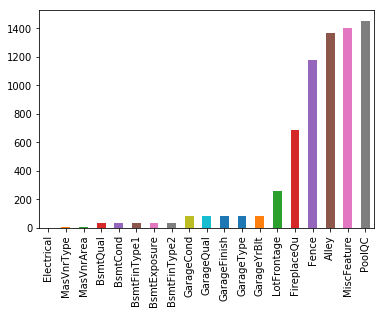

In [5]:
# Number of Missing Observations in Qualitative Variables
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

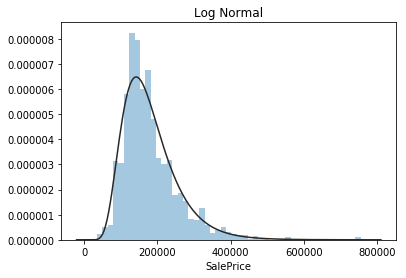

In [6]:
plt.figure(1); plt.title('Log Normal')
sns.distplot(train['SalePrice'], kde=False, fit=st.lognorm)

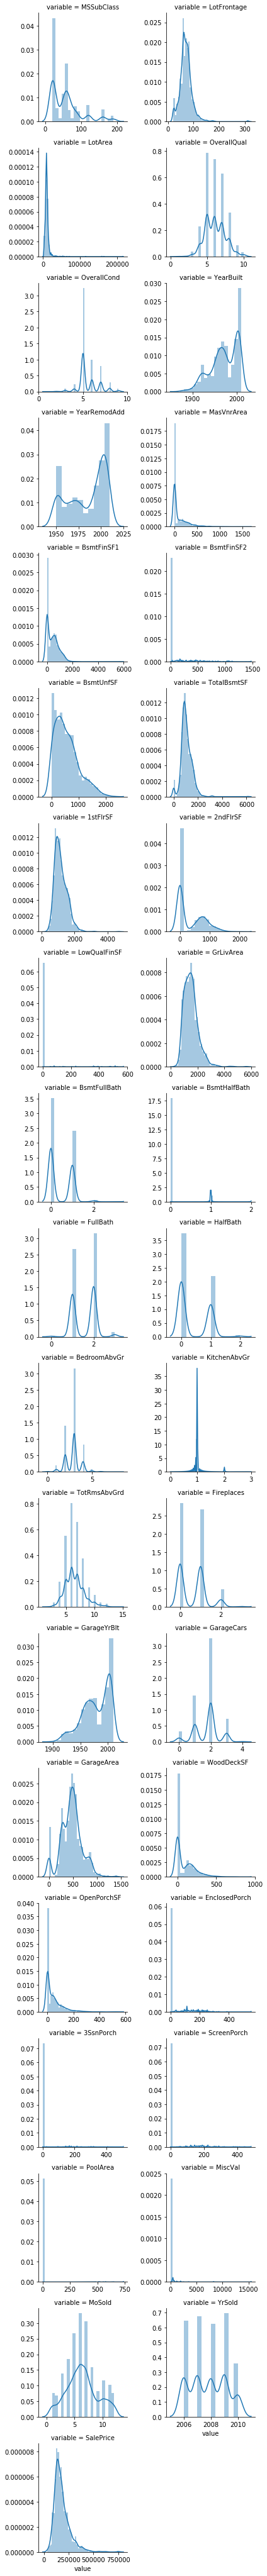

In [7]:
train_quant_var = [f for f in train.columns if train.dtypes[f] != 'object']
train_quant_var.remove('Id')

f = pd.melt(train, value_vars=train_quant_var)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

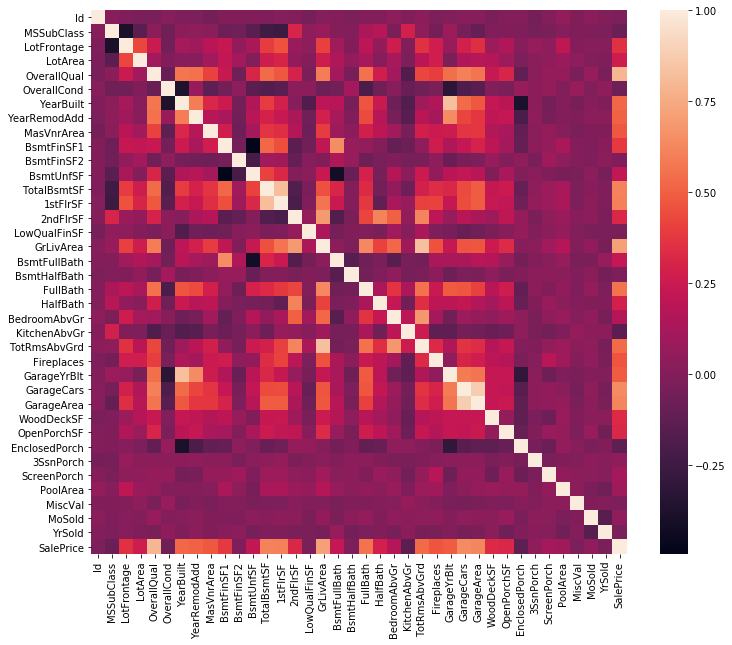

In [8]:
corr_matrix = train.corr()
fig, axes = plt.subplots(figsize = (12,10))
sns.heatmap(corr_matrix, vmax=1.0)

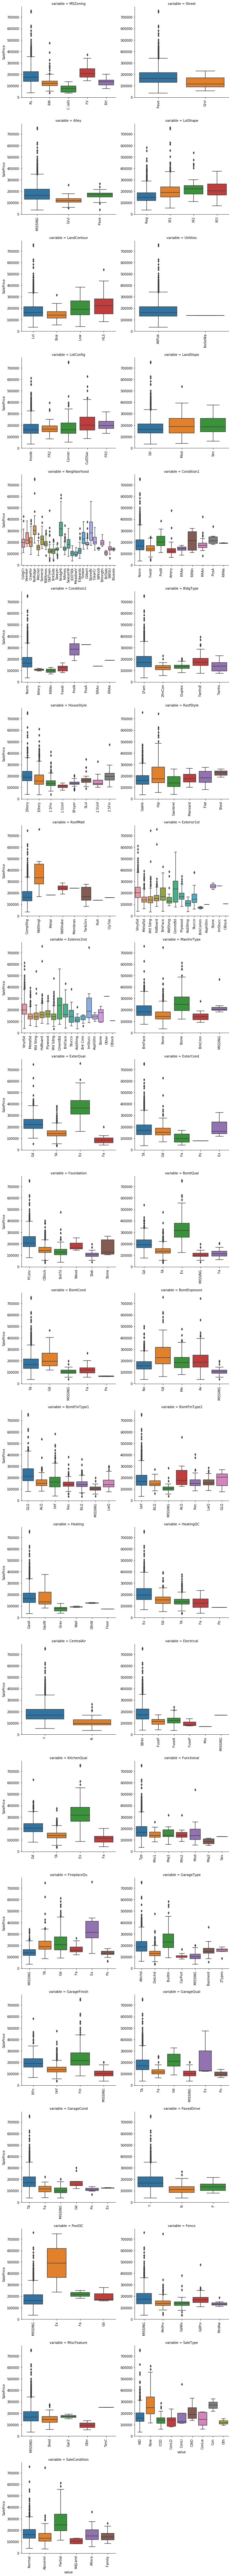

In [9]:
train_qual_var = [f for f in train.columns if train.dtypes[f] == 'object']

for c in train_qual_var:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=train_qual_var)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

In [10]:
lb_Neighborhood = LabelEncoder()
train['NeighborhoodCode'] = lb_Neighborhood.fit_transform(train['Neighborhood'])
test['NeighborhoodCode'] = lb_Neighborhood.fit_transform(test['Neighborhood'])

In [11]:
predictor_columns = ['LotArea', 'YearBuilt', 'GrLivArea', 'FullBath', 
                     'TotRmsAbvGrd','NeighborhoodCode','OverallQual']

In [12]:
train_X = train[predictor_columns]
test_X = test[predictor_columns]
train_Y = train.SalePrice

In [13]:
forest_model = RandomForestRegressor()
forest_model.fit(train_X, train_Y)
forest_sales_price_prediction = forest_model.predict(test_X)

In [14]:
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': forest_sales_price_prediction})

In [15]:
my_submission.to_csv('my_submission.csv', index=False)

In [16]:
# Score: RMSE = 0.16344
#Submissions are evaluated on Root-Mean-Squared-Error (RMSE) 
#between the logarithm of the predicted value and the logarithm 
#of the observed sales price. 
#(Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)